In [1]:
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Softloss(nn.Module):
    def __init__(self,T=4,loss_portion=[1,0,0]) -> None:
        '''
        T: temperature
        loss_portion: KLD, cosine, mse
        '''
        super(Softloss,self).__init__()
        self.T=T
        self.portion=loss_portion
    def forward(self,x,y):
        soft_x=F.log_softmax(x/self.T,dim=-1)
        soft_y=F.softmax(y/self.T,dim=-1)
        loss=self.portion[0]*F.kl_div(soft_x,soft_y,reduction="batchmean")\
            +self.portion[1]*F.cosine_embedding_loss(soft_x,soft_y,torch.ones(soft_x.shape[0]).to(soft_x.device))\
            +self.portion[2]*F.mse_loss(soft_x,soft_y)
        return loss*self.T*self.T


In [3]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.layers=nn.Sequential(nn.Flatten(),
                                    #nn.Dropout(0.2),
                                    nn.Linear(28*28,1200),
                                    #n.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(1200,10))
    def forward(self,x):
        return self.layers(x)


In [4]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.layers=nn.Sequential(nn.Flatten(),
                                    nn.Linear(28*28,400),
                                    nn.ReLU(),
                                    nn.Linear(400,10))
    def forward(self,x):
        return self.layers(x)

In [5]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform = transforms.Compose(
    
    (transforms.ToTensor(),)
    
)
transform_train = transforms.Compose(
    (
    
    transforms.RandomCrop((28,28),padding=2),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    
    #
    #transforms.ColorJitter(0.2,0,0)
    
    )
)

transform_val = transform
#############################################
# do NOT change these
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset


val_set = MNIST(
    root=DATA_ROOT, 
    train=False, 
    download=True,
    transform=transform_val    # your code
)

# construct dataloader


val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=2
)
#############################################

In [6]:
def remove_data(target,keep=False,train=True,transform=transform_train,dataset=MNIST):
    data = dataset(
    root=DATA_ROOT, 
    train=train, 
    download=True,
    transform=transform)
    new_data=[]
    new_target=[]
    for i in range(data.data.shape[0]):
        if data.targets[i] in target:
            if keep:
                new_data.append(data.data[i].clone().detach().tolist())
                new_target.append(data.targets[i])
        else:
            if not keep:        
                new_data.append(data.data[i].clone().detach().tolist())
                new_target.append(data.targets[i])
    data.data=torch.tensor(new_data,dtype=data.data.dtype)
    data.targets=torch.tensor(new_target)
    loader = DataLoader(
    data, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=train,     # your code
    num_workers=2
    )
    return loader



In [7]:
import torch.nn as nn
import torch.optim as optim


In [8]:
def train(T,portion,alpha,train_loader,val_loader,special_loader,EPOCHS=150):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    student=Student()
    student=student.to(device)
    model=student
    teacher=Teacher()
    state=torch.load("./saved_model/teacher_9928.pth")["state_dict"]
    teacher.load_state_dict(state)
    teacher=teacher.to(device)
    state=None
    # some hyperparameters
    # total number of training epochs
    teacher.eval()
    # hyperparameters, do NOT change right now
    # initial learning rate
    INITIAL_LR = 0.1

    # momentum for optimizer
    MOMENTUM = 0.9

    # L2 regularization strength
    REG = 0.00
    criterion = nn.CrossEntropyLoss()

    # Add optimizer
    optimizer = optim.SGD(student.parameters(),lr=INITIAL_LR,momentum=MOMENTUM,nesterov=True)
    soft_criterion=Softloss(T,portion)
    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "./tmp_model"
    DECAY_EPOCHS=1
    DECAY=0.95
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = INITIAL_LR
    best_special_acc=0
    print("==> Training starts!")
    print("="*50)
    for i in range(0, EPOCHS):
        # handle the learning rate scheduler.
        
        if i % DECAY_EPOCHS == 0 and i != 0 :
            current_learning_rate = current_learning_rate * DECAY
        
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            #print("Current learning rate has decayed to %f" %current_learning_rate)
        
        #######################
        # your code here
        # switch to train mode
        model.train()
        
        #######################
        
        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want
        loader=train_loader
        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs=inputs.to(device)
            targets=targets.to(device).long()

            
            # compute the output and loss
            out=model(inputs)
            with torch.no_grad():
                soft_target=teacher(inputs)
            loss=(1-alpha)*criterion(out,targets)+alpha*soft_criterion(out,soft_target)
            
            # zero the gradient
            
            optimizer.zero_grad()
            # backpropagation
            loss.backward()

            
            # apply gradient and update the weights
            optimizer.step()
            train_loss+=loss.item()
            
            # count the number of correctly predicted samples in the current batch
            correct_examples+=torch.sum(out.argmax(-1)==targets).item()
            ####################################
        total_examples=len(train_loader.dataset)      
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        total_examples = 0
        correct_examples = 0
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(special_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs=inputs.to(device)
                targets=targets.to(device).long()
                # compute the output and loss
                out=model(inputs)
                loss=criterion(out,targets)
                # count the number of correctly predicted samples in the current batch
                val_loss+=loss.item()
                correct_examples+=torch.sum(out.argmax(-1)==targets).item()
                
                ####################################
        total_examples=len(special_loader.dataset)
        avg_loss = val_loss / total_examples
        avg_acc = correct_examples / total_examples
        print("Special Validation loss: %.4f, Specail Validation accuracy: %.4f" % (avg_loss, avg_acc))
        if best_special_acc<avg_acc:
            best_special_acc=avg_acc


        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs=inputs.to(device)
                targets=targets.to(device).long()
                # compute the output and loss
                out=model(inputs)
                loss=criterion(out,targets)
                # count the number of correctly predicted samples in the current batch
                val_loss+=loss.item()
                correct_examples+=torch.sum(out.argmax(-1)==targets).item()
                
                ####################################
        total_examples=len(val_loader.dataset)
        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
                os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    }
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, str(T)+'_distilled.pth'))
            

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    print(f"==> Optimization finished! Best special accuracy: {best_special_acc:.4f}")
    return best_val_acc

In [9]:
T=6

In [10]:
train_loader=remove_data(target=[0],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[0],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 3.0670, Training accuracy: 0.9081
Special Validation loss: 0.0035, Specail Validation accuracy: 0.8571
Validation loss: 0.0948, Validation accuracy: 0.9689
Saving ...
Epoch 1:
Training loss: 0.7023, Training accuracy: 0.9757
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9561
Validation loss: 0.0549, Validation accuracy: 0.9819
Saving ...
Epoch 2:
Training loss: 0.5157, Training accuracy: 0.9812
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9755
Validation loss: 0.0444, Validation accuracy: 0.9859
Saving ...
Epoch 3:
Training loss: 0.4333, Training accuracy: 0.9831
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9765
Validation loss: 0.0439, Validation accuracy: 0.9850
Epoch 4:
Training loss: 0.3814, Training accuracy: 0.9840
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9806
Validation loss: 0.0397, Validation accuracy: 0.9863
Saving ...
Epoch 5:
Training loss: 0.3464, Tra

Special Validation loss: 0.0003, Specail Validation accuracy: 0.9898
Validation loss: 0.0290, Validation accuracy: 0.9909
Epoch 45:
Training loss: 0.1726, Training accuracy: 0.9897
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9908
Validation loss: 0.0284, Validation accuracy: 0.9905
Epoch 46:
Training loss: 0.1721, Training accuracy: 0.9895
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9908
Validation loss: 0.0286, Validation accuracy: 0.9911
Epoch 47:
Training loss: 0.1719, Training accuracy: 0.9893
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9908
Validation loss: 0.0284, Validation accuracy: 0.9907
Epoch 48:
Training loss: 0.1718, Training accuracy: 0.9894
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0285, Validation accuracy: 0.9908
Epoch 49:
Training loss: 0.1711, Training accuracy: 0.9895
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0290, V

Validation loss: 0.0285, Validation accuracy: 0.9909
Epoch 90:
Training loss: 0.1623, Training accuracy: 0.9895
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0285, Validation accuracy: 0.9908
Epoch 91:
Training loss: 0.1622, Training accuracy: 0.9895
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0285, Validation accuracy: 0.9909
Epoch 92:
Training loss: 0.1623, Training accuracy: 0.9897
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0285, Validation accuracy: 0.9910
Epoch 93:
Training loss: 0.1621, Training accuracy: 0.9892
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9910
Epoch 94:
Training loss: 0.1630, Training accuracy: 0.9895
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9909
Epoch 95:
Training loss: 0.1616, Training 

Training loss: 0.1604, Training accuracy: 0.9898
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9909
Epoch 136:
Training loss: 0.1614, Training accuracy: 0.9894
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9909
Epoch 137:
Training loss: 0.1621, Training accuracy: 0.9897
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9908
Epoch 138:
Training loss: 0.1608, Training accuracy: 0.9902
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0284, Validation accuracy: 0.9909
Epoch 139:
Training loss: 0.1614, Training accuracy: 0.9900
Special Validation loss: 0.0002, Specail Validation accuracy: 0.9898
Validation loss: 0.0283, Validation accuracy: 0.9908
Epoch 140:
Training loss: 0.1609, Training accuracy: 0.9897
Special Validation loss: 0.0002, Specail 

0.9911

In [11]:
train_loader=remove_data(target=[1],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[1],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 3.6082, Training accuracy: 0.8989
Special Validation loss: 0.0094, Specail Validation accuracy: 0.5789
Validation loss: 0.2815, Validation accuracy: 0.9072
Saving ...
Epoch 1:
Training loss: 0.9701, Training accuracy: 0.9712
Special Validation loss: 0.0046, Specail Validation accuracy: 0.7242
Validation loss: 0.1276, Validation accuracy: 0.9491
Saving ...
Epoch 2:
Training loss: 0.7296, Training accuracy: 0.9769
Special Validation loss: 0.0012, Specail Validation accuracy: 0.9700
Validation loss: 0.0593, Validation accuracy: 0.9836
Saving ...
Epoch 3:
Training loss: 0.6148, Training accuracy: 0.9794
Special Validation loss: 0.0020, Specail Validation accuracy: 0.9093
Validation loss: 0.0734, Validation accuracy: 0.9744
Epoch 4:
Training loss: 0.5583, Training accuracy: 0.9810
Special Validation loss: 0.0012, Specail Validation accuracy: 0.9621
Validation loss: 0.0578, Validation accuracy: 0.9821
Epoch 5:
Training loss: 0.5107, Training accur

Special Validation loss: 0.0006, Specail Validation accuracy: 0.9806
Validation loss: 0.0384, Validation accuracy: 0.9877
Epoch 45:
Training loss: 0.2737, Training accuracy: 0.9883
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9824
Validation loss: 0.0383, Validation accuracy: 0.9878
Epoch 46:
Training loss: 0.2728, Training accuracy: 0.9879
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9824
Validation loss: 0.0386, Validation accuracy: 0.9879
Epoch 47:
Training loss: 0.2704, Training accuracy: 0.9881
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9806
Validation loss: 0.0392, Validation accuracy: 0.9876
Epoch 48:
Training loss: 0.2725, Training accuracy: 0.9877
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9806
Validation loss: 0.0386, Validation accuracy: 0.9879
Epoch 49:
Training loss: 0.2714, Training accuracy: 0.9879
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9806
Validation loss: 0.0391, V

Validation loss: 0.0382, Validation accuracy: 0.9884
Epoch 90:
Training loss: 0.2578, Training accuracy: 0.9877
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0381, Validation accuracy: 0.9885
Epoch 91:
Training loss: 0.2585, Training accuracy: 0.9876
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0382, Validation accuracy: 0.9883
Epoch 92:
Training loss: 0.2598, Training accuracy: 0.9880
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0384, Validation accuracy: 0.9884
Epoch 93:
Training loss: 0.2590, Training accuracy: 0.9876
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0380, Validation accuracy: 0.9886
Epoch 94:
Training loss: 0.2569, Training accuracy: 0.9886
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0381, Validation accuracy: 0.9884
Epoch 95:
Training loss: 0.2568, Training 

Training loss: 0.2590, Training accuracy: 0.9881
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0382, Validation accuracy: 0.9885
Epoch 136:
Training loss: 0.2548, Training accuracy: 0.9880
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0383, Validation accuracy: 0.9885
Epoch 137:
Training loss: 0.2565, Training accuracy: 0.9879
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0383, Validation accuracy: 0.9885
Epoch 138:
Training loss: 0.2562, Training accuracy: 0.9886
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0382, Validation accuracy: 0.9885
Epoch 139:
Training loss: 0.2566, Training accuracy: 0.9883
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9815
Validation loss: 0.0382, Validation accuracy: 0.9885
Epoch 140:
Training loss: 0.2572, Training accuracy: 0.9876
Special Validation loss: 0.0006, Specail 

0.9886

In [12]:
train_loader=remove_data(target=[2],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[2],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 3.2545, Training accuracy: 0.9056
Special Validation loss: 0.0078, Specail Validation accuracy: 0.6802
Validation loss: 0.1502, Validation accuracy: 0.9485
Saving ...
Epoch 1:
Training loss: 0.8158, Training accuracy: 0.9753
Special Validation loss: 0.0034, Specail Validation accuracy: 0.8576
Validation loss: 0.0830, Validation accuracy: 0.9713
Saving ...
Epoch 2:
Training loss: 0.6029, Training accuracy: 0.9802
Special Validation loss: 0.0026, Specail Validation accuracy: 0.8886
Validation loss: 0.0732, Validation accuracy: 0.9752
Saving ...
Epoch 3:
Training loss: 0.5159, Training accuracy: 0.9830
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9370
Validation loss: 0.0535, Validation accuracy: 0.9804
Saving ...
Epoch 4:
Training loss: 0.4567, Training accuracy: 0.9833
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9360
Validation loss: 0.0454, Validation accuracy: 0.9825
Saving ...
Epoch 5:
Training loss: 

Special Validation loss: 0.0005, Specail Validation accuracy: 0.9758
Validation loss: 0.0321, Validation accuracy: 0.9882
Epoch 45:
Training loss: 0.2075, Training accuracy: 0.9893
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9748
Validation loss: 0.0325, Validation accuracy: 0.9887
Epoch 46:
Training loss: 0.2063, Training accuracy: 0.9893
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9748
Validation loss: 0.0322, Validation accuracy: 0.9881
Epoch 47:
Training loss: 0.2073, Training accuracy: 0.9895
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9738
Validation loss: 0.0325, Validation accuracy: 0.9883
Epoch 48:
Training loss: 0.2062, Training accuracy: 0.9895
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9758
Validation loss: 0.0321, Validation accuracy: 0.9885
Epoch 49:
Training loss: 0.2058, Training accuracy: 0.9898
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0322, V

Validation loss: 0.0317, Validation accuracy: 0.9886
Epoch 90:
Training loss: 0.1954, Training accuracy: 0.9902
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0318, Validation accuracy: 0.9885
Epoch 91:
Training loss: 0.1955, Training accuracy: 0.9896
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0318, Validation accuracy: 0.9887
Epoch 92:
Training loss: 0.1952, Training accuracy: 0.9903
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9787
Validation loss: 0.0316, Validation accuracy: 0.9885
Epoch 93:
Training loss: 0.1956, Training accuracy: 0.9900
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9787
Validation loss: 0.0316, Validation accuracy: 0.9886
Epoch 94:
Training loss: 0.1952, Training accuracy: 0.9897
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9787
Validation loss: 0.0317, Validation accuracy: 0.9886
Epoch 95:
Training loss: 0.1954, Training 

Training loss: 0.1944, Training accuracy: 0.9900
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0317, Validation accuracy: 0.9887
Epoch 136:
Training loss: 0.1938, Training accuracy: 0.9897
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0317, Validation accuracy: 0.9887
Epoch 137:
Training loss: 0.1942, Training accuracy: 0.9899
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0317, Validation accuracy: 0.9887
Epoch 138:
Training loss: 0.1947, Training accuracy: 0.9894
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0317, Validation accuracy: 0.9887
Epoch 139:
Training loss: 0.1938, Training accuracy: 0.9899
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9777
Validation loss: 0.0317, Validation accuracy: 0.9888
Epoch 140:
Training loss: 0.1942, Training accuracy: 0.9899
Special Validation loss: 0.0005, Specail 

0.989

In [13]:
train_loader=remove_data(target=[3],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[3],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 3.0026, Training accuracy: 0.9166
Special Validation loss: 0.0050, Specail Validation accuracy: 0.7614
Validation loss: 0.1137, Validation accuracy: 0.9603
Saving ...
Epoch 1:
Training loss: 0.6810, Training accuracy: 0.9796
Special Validation loss: 0.0029, Specail Validation accuracy: 0.8703
Validation loss: 0.0763, Validation accuracy: 0.9738
Saving ...
Epoch 2:
Training loss: 0.5085, Training accuracy: 0.9832
Special Validation loss: 0.0017, Specail Validation accuracy: 0.9257
Validation loss: 0.0533, Validation accuracy: 0.9819
Saving ...
Epoch 3:
Training loss: 0.4201, Training accuracy: 0.9852
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9406
Validation loss: 0.0488, Validation accuracy: 0.9839
Saving ...
Epoch 4:
Training loss: 0.3738, Training accuracy: 0.9858
Special Validation loss: 0.0014, Specail Validation accuracy: 0.9416
Validation loss: 0.0482, Validation accuracy: 0.9838
Epoch 5:
Training loss: 0.3423, Tra

Special Validation loss: 0.0004, Specail Validation accuracy: 0.9812
Validation loss: 0.0311, Validation accuracy: 0.9889
Epoch 45:
Training loss: 0.1696, Training accuracy: 0.9906
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0312, Validation accuracy: 0.9887
Epoch 46:
Training loss: 0.1681, Training accuracy: 0.9904
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0310, Validation accuracy: 0.9889
Epoch 47:
Training loss: 0.1676, Training accuracy: 0.9900
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9782
Validation loss: 0.0310, Validation accuracy: 0.9893
Epoch 48:
Training loss: 0.1670, Training accuracy: 0.9905
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9792
Validation loss: 0.0312, Validation accuracy: 0.9888
Epoch 49:
Training loss: 0.1672, Training accuracy: 0.9907
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0306, V

Validation loss: 0.0307, Validation accuracy: 0.9887
Epoch 90:
Training loss: 0.1591, Training accuracy: 0.9914
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0307, Validation accuracy: 0.9888
Epoch 91:
Training loss: 0.1594, Training accuracy: 0.9907
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0306, Validation accuracy: 0.9888
Epoch 92:
Training loss: 0.1598, Training accuracy: 0.9909
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0307, Validation accuracy: 0.9889
Epoch 93:
Training loss: 0.1587, Training accuracy: 0.9907
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0306, Validation accuracy: 0.9889
Epoch 94:
Training loss: 0.1596, Training accuracy: 0.9912
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0305, Validation accuracy: 0.9888
Epoch 95:
Training loss: 0.1586, Training 

Training loss: 0.1586, Training accuracy: 0.9910
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0306, Validation accuracy: 0.9888
Epoch 136:
Training loss: 0.1584, Training accuracy: 0.9908
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0306, Validation accuracy: 0.9888
Epoch 137:
Training loss: 0.1584, Training accuracy: 0.9913
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0306, Validation accuracy: 0.9889
Epoch 138:
Training loss: 0.1588, Training accuracy: 0.9911
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9802
Validation loss: 0.0306, Validation accuracy: 0.9888
Epoch 139:
Training loss: 0.1576, Training accuracy: 0.9909
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9792
Validation loss: 0.0306, Validation accuracy: 0.9887
Epoch 140:
Training loss: 0.1591, Training accuracy: 0.9908
Special Validation loss: 0.0004, Specail 

0.9897

In [14]:
train_loader=remove_data(target=[4],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[4],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 2.6686, Training accuracy: 0.9227
Special Validation loss: 0.0080, Specail Validation accuracy: 0.6018
Validation loss: 0.1706, Validation accuracy: 0.9388
Saving ...
Epoch 1:
Training loss: 0.5957, Training accuracy: 0.9788
Special Validation loss: 0.0031, Specail Validation accuracy: 0.8483
Validation loss: 0.0845, Validation accuracy: 0.9697
Saving ...
Epoch 2:
Training loss: 0.4301, Training accuracy: 0.9838
Special Validation loss: 0.0020, Specail Validation accuracy: 0.9043
Validation loss: 0.0562, Validation accuracy: 0.9802
Saving ...
Epoch 3:
Training loss: 0.3529, Training accuracy: 0.9854
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9654
Validation loss: 0.0431, Validation accuracy: 0.9857
Saving ...
Epoch 4:
Training loss: 0.3074, Training accuracy: 0.9877
Special Validation loss: 0.0009, Specail Validation accuracy: 0.9532
Validation loss: 0.0429, Validation accuracy: 0.9848
Epoch 5:
Training loss: 0.2734, Tra

Training loss: 0.1214, Training accuracy: 0.9914
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0290, Validation accuracy: 0.9900
Epoch 45:
Training loss: 0.1212, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0289, Validation accuracy: 0.9901
Epoch 46:
Training loss: 0.1212, Training accuracy: 0.9917
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0294, Validation accuracy: 0.9902
Epoch 47:
Training loss: 0.1200, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9807
Validation loss: 0.0294, Validation accuracy: 0.9904
Epoch 48:
Training loss: 0.1203, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0294, Validation accuracy: 0.9901
Epoch 49:
Training loss: 0.1198, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail Valid

Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0286, Validation accuracy: 0.9904
Epoch 90:
Training loss: 0.1137, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9905
Epoch 91:
Training loss: 0.1131, Training accuracy: 0.9924
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9904
Epoch 92:
Training loss: 0.1134, Training accuracy: 0.9923
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9904
Epoch 93:
Training loss: 0.1128, Training accuracy: 0.9920
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9904
Epoch 94:
Training loss: 0.1132, Training accuracy: 0.9917
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0287, V

Validation loss: 0.0288, Validation accuracy: 0.9904
Epoch 135:
Training loss: 0.1122, Training accuracy: 0.9924
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9903
Epoch 136:
Training loss: 0.1125, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9903
Epoch 137:
Training loss: 0.1129, Training accuracy: 0.9921
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9903
Epoch 138:
Training loss: 0.1120, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9904
Epoch 139:
Training loss: 0.1126, Training accuracy: 0.9919
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9796
Validation loss: 0.0288, Validation accuracy: 0.9903
Epoch 140:
Training loss: 0.1122, Tra

0.9907

In [15]:
train_loader=remove_data(target=[5],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[5],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 2.6300, Training accuracy: 0.9245
Special Validation loss: 0.0057, Specail Validation accuracy: 0.7287
Validation loss: 0.1059, Validation accuracy: 0.9622
Saving ...
Epoch 1:
Training loss: 0.5651, Training accuracy: 0.9799
Special Validation loss: 0.0024, Specail Validation accuracy: 0.8957
Validation loss: 0.0633, Validation accuracy: 0.9788
Saving ...
Epoch 2:
Training loss: 0.4104, Training accuracy: 0.9847
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9428
Validation loss: 0.0471, Validation accuracy: 0.9831
Saving ...
Epoch 3:
Training loss: 0.3388, Training accuracy: 0.9862
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9462
Validation loss: 0.0427, Validation accuracy: 0.9856
Saving ...
Epoch 4:
Training loss: 0.2994, Training accuracy: 0.9871
Special Validation loss: 0.0009, Specail Validation accuracy: 0.9608
Validation loss: 0.0391, Validation accuracy: 0.9867
Saving ...
Epoch 5:
Training loss: 

Special Validation loss: 0.0005, Specail Validation accuracy: 0.9821
Validation loss: 0.0279, Validation accuracy: 0.9905
Epoch 45:
Training loss: 0.1220, Training accuracy: 0.9917
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9907
Epoch 46:
Training loss: 0.1212, Training accuracy: 0.9914
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0282, Validation accuracy: 0.9908
Epoch 47:
Training loss: 0.1206, Training accuracy: 0.9915
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0282, Validation accuracy: 0.9907
Epoch 48:
Training loss: 0.1203, Training accuracy: 0.9912
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0278, Validation accuracy: 0.9910
Epoch 49:
Training loss: 0.1197, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0280, V

Validation loss: 0.0280, Validation accuracy: 0.9908
Epoch 90:
Training loss: 0.1128, Training accuracy: 0.9914
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 91:
Training loss: 0.1125, Training accuracy: 0.9917
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9909
Epoch 92:
Training loss: 0.1132, Training accuracy: 0.9917
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0280, Validation accuracy: 0.9909
Epoch 93:
Training loss: 0.1131, Training accuracy: 0.9909
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 94:
Training loss: 0.1126, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0280, Validation accuracy: 0.9909
Epoch 95:
Training loss: 0.1130, Training 

Training loss: 0.1128, Training accuracy: 0.9916
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9911
Epoch 136:
Training loss: 0.1122, Training accuracy: 0.9919
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 137:
Training loss: 0.1129, Training accuracy: 0.9919
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 138:
Training loss: 0.1120, Training accuracy: 0.9915
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 139:
Training loss: 0.1120, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9798
Validation loss: 0.0279, Validation accuracy: 0.9910
Epoch 140:
Training loss: 0.1126, Training accuracy: 0.9918
Special Validation loss: 0.0005, Specail 

0.9913

In [16]:
train_loader=remove_data(target=[6],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[6],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 2.8509, Training accuracy: 0.9156
Special Validation loss: 0.0056, Specail Validation accuracy: 0.7683
Validation loss: 0.1103, Validation accuracy: 0.9621
Saving ...
Epoch 1:
Training loss: 0.6343, Training accuracy: 0.9779
Special Validation loss: 0.0015, Specail Validation accuracy: 0.9509
Validation loss: 0.0499, Validation accuracy: 0.9836
Saving ...
Epoch 2:
Training loss: 0.4612, Training accuracy: 0.9827
Special Validation loss: 0.0012, Specail Validation accuracy: 0.9572
Validation loss: 0.0507, Validation accuracy: 0.9831
Epoch 3:
Training loss: 0.3837, Training accuracy: 0.9845
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9739
Validation loss: 0.0405, Validation accuracy: 0.9870
Saving ...
Epoch 4:
Training loss: 0.3398, Training accuracy: 0.9858
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9760
Validation loss: 0.0367, Validation accuracy: 0.9880
Saving ...
Epoch 5:
Training loss: 0.3072, Tra

Special Validation loss: 0.0003, Specail Validation accuracy: 0.9833
Validation loss: 0.0288, Validation accuracy: 0.9898
Epoch 45:
Training loss: 0.1420, Training accuracy: 0.9908
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9833
Validation loss: 0.0285, Validation accuracy: 0.9903
Epoch 46:
Training loss: 0.1411, Training accuracy: 0.9904
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9864
Validation loss: 0.0283, Validation accuracy: 0.9907
Epoch 47:
Training loss: 0.1409, Training accuracy: 0.9903
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9843
Validation loss: 0.0284, Validation accuracy: 0.9904
Epoch 48:
Training loss: 0.1404, Training accuracy: 0.9903
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9854
Validation loss: 0.0280, Validation accuracy: 0.9904
Epoch 49:
Training loss: 0.1401, Training accuracy: 0.9905
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0279, V

Validation loss: 0.0279, Validation accuracy: 0.9906
Epoch 90:
Training loss: 0.1319, Training accuracy: 0.9905
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0279, Validation accuracy: 0.9903
Epoch 91:
Training loss: 0.1317, Training accuracy: 0.9907
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0279, Validation accuracy: 0.9907
Epoch 92:
Training loss: 0.1314, Training accuracy: 0.9907
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9864
Validation loss: 0.0278, Validation accuracy: 0.9908
Epoch 93:
Training loss: 0.1316, Training accuracy: 0.9908
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0279, Validation accuracy: 0.9906
Epoch 94:
Training loss: 0.1316, Training accuracy: 0.9906
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0279, Validation accuracy: 0.9906
Epoch 95:
Training loss: 0.1314, Training 

Training loss: 0.1304, Training accuracy: 0.9913
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0278, Validation accuracy: 0.9904
Epoch 136:
Training loss: 0.1305, Training accuracy: 0.9908
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0278, Validation accuracy: 0.9904
Epoch 137:
Training loss: 0.1310, Training accuracy: 0.9912
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0278, Validation accuracy: 0.9904
Epoch 138:
Training loss: 0.1306, Training accuracy: 0.9909
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0277, Validation accuracy: 0.9905
Epoch 139:
Training loss: 0.1306, Training accuracy: 0.9911
Special Validation loss: 0.0003, Specail Validation accuracy: 0.9843
Validation loss: 0.0278, Validation accuracy: 0.9905
Epoch 140:
Training loss: 0.1306, Training accuracy: 0.9912
Special Validation loss: 0.0003, Specail 

0.991

In [17]:
train_loader=remove_data(target=[7],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[7],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 3.2647, Training accuracy: 0.9092
Special Validation loss: 0.0062, Specail Validation accuracy: 0.7160
Validation loss: 0.1347, Validation accuracy: 0.9531
Saving ...
Epoch 1:
Training loss: 0.7670, Training accuracy: 0.9768
Special Validation loss: 0.0025, Specail Validation accuracy: 0.8881
Validation loss: 0.0741, Validation accuracy: 0.9750
Saving ...
Epoch 2:
Training loss: 0.5695, Training accuracy: 0.9807
Special Validation loss: 0.0022, Specail Validation accuracy: 0.8852
Validation loss: 0.0603, Validation accuracy: 0.9765
Saving ...
Epoch 3:
Training loss: 0.4803, Training accuracy: 0.9830
Special Validation loss: 0.0022, Specail Validation accuracy: 0.8940
Validation loss: 0.0621, Validation accuracy: 0.9772
Saving ...
Epoch 4:
Training loss: 0.4282, Training accuracy: 0.9844
Special Validation loss: 0.0012, Specail Validation accuracy: 0.9514
Validation loss: 0.0461, Validation accuracy: 0.9841
Saving ...
Epoch 5:
Training loss: 

Special Validation loss: 0.0007, Specail Validation accuracy: 0.9747
Validation loss: 0.0321, Validation accuracy: 0.9892
Epoch 45:
Training loss: 0.2041, Training accuracy: 0.9893
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0324, Validation accuracy: 0.9898
Epoch 46:
Training loss: 0.2036, Training accuracy: 0.9901
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0325, Validation accuracy: 0.9898
Epoch 47:
Training loss: 0.2033, Training accuracy: 0.9895
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9776
Validation loss: 0.0318, Validation accuracy: 0.9899
Epoch 48:
Training loss: 0.2039, Training accuracy: 0.9899
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9776
Validation loss: 0.0316, Validation accuracy: 0.9898
Epoch 49:
Training loss: 0.2014, Training accuracy: 0.9896
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0323, V

Validation loss: 0.0319, Validation accuracy: 0.9902
Epoch 90:
Training loss: 0.1933, Training accuracy: 0.9900
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9767
Validation loss: 0.0319, Validation accuracy: 0.9902
Epoch 91:
Training loss: 0.1923, Training accuracy: 0.9898
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9776
Validation loss: 0.0318, Validation accuracy: 0.9902
Epoch 92:
Training loss: 0.1919, Training accuracy: 0.9900
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0321, Validation accuracy: 0.9899
Epoch 93:
Training loss: 0.1929, Training accuracy: 0.9894
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9767
Validation loss: 0.0319, Validation accuracy: 0.9900
Epoch 94:
Training loss: 0.1922, Training accuracy: 0.9903
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9747
Validation loss: 0.0320, Validation accuracy: 0.9898
Epoch 95:
Training loss: 0.1920, Training 

Training loss: 0.1912, Training accuracy: 0.9899
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0320, Validation accuracy: 0.9899
Epoch 136:
Training loss: 0.1901, Training accuracy: 0.9901
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9767
Validation loss: 0.0319, Validation accuracy: 0.9900
Epoch 137:
Training loss: 0.1910, Training accuracy: 0.9897
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0320, Validation accuracy: 0.9899
Epoch 138:
Training loss: 0.1917, Training accuracy: 0.9897
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9757
Validation loss: 0.0320, Validation accuracy: 0.9899
Epoch 139:
Training loss: 0.1911, Training accuracy: 0.9897
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9767
Validation loss: 0.0320, Validation accuracy: 0.9900
Epoch 140:
Training loss: 0.1923, Training accuracy: 0.9896
Special Validation loss: 0.0007, Specail 

0.9905

In [18]:
train_loader=remove_data(target=[8],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[8],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 2.5475, Training accuracy: 0.9299
Special Validation loss: 0.0109, Specail Validation accuracy: 0.4979
Validation loss: 0.1868, Validation accuracy: 0.9327
Saving ...
Epoch 1:
Training loss: 0.5742, Training accuracy: 0.9809
Special Validation loss: 0.0035, Specail Validation accuracy: 0.8388
Validation loss: 0.0832, Validation accuracy: 0.9704
Saving ...
Epoch 2:
Training loss: 0.4115, Training accuracy: 0.9848
Special Validation loss: 0.0025, Specail Validation accuracy: 0.8943
Validation loss: 0.0737, Validation accuracy: 0.9745
Saving ...
Epoch 3:
Training loss: 0.3425, Training accuracy: 0.9863
Special Validation loss: 0.0016, Specail Validation accuracy: 0.9384
Validation loss: 0.0463, Validation accuracy: 0.9847
Saving ...
Epoch 4:
Training loss: 0.2977, Training accuracy: 0.9880
Special Validation loss: 0.0019, Specail Validation accuracy: 0.9230
Validation loss: 0.0789, Validation accuracy: 0.9772
Epoch 5:
Training loss: 0.2834, Tra

Training loss: 0.1185, Training accuracy: 0.9917
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9836
Validation loss: 0.0281, Validation accuracy: 0.9906
Epoch 45:
Training loss: 0.1185, Training accuracy: 0.9922
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9825
Validation loss: 0.0282, Validation accuracy: 0.9901
Epoch 46:
Training loss: 0.1176, Training accuracy: 0.9919
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9825
Validation loss: 0.0285, Validation accuracy: 0.9905
Epoch 47:
Training loss: 0.1169, Training accuracy: 0.9920
Special Validation loss: 0.0005, Specail Validation accuracy: 0.9825
Validation loss: 0.0283, Validation accuracy: 0.9906
Epoch 48:
Training loss: 0.1171, Training accuracy: 0.9920
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9815
Validation loss: 0.0280, Validation accuracy: 0.9902
Epoch 49:
Training loss: 0.1173, Training accuracy: 0.9912
Special Validation loss: 0.0005, Specail Valid

Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, Validation accuracy: 0.9902
Epoch 90:
Training loss: 0.1099, Training accuracy: 0.9918
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, Validation accuracy: 0.9903
Epoch 91:
Training loss: 0.1101, Training accuracy: 0.9918
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, Validation accuracy: 0.9903
Epoch 92:
Training loss: 0.1100, Training accuracy: 0.9925
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, Validation accuracy: 0.9904
Epoch 93:
Training loss: 0.1102, Training accuracy: 0.9922
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, Validation accuracy: 0.9904
Epoch 94:
Training loss: 0.1096, Training accuracy: 0.9925
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0279, V

Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 135:
Training loss: 0.1084, Training accuracy: 0.9924
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 136:
Training loss: 0.1087, Training accuracy: 0.9924
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 137:
Training loss: 0.1096, Training accuracy: 0.9921
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 138:
Training loss: 0.1095, Training accuracy: 0.9918
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 139:
Training loss: 0.1094, Training accuracy: 0.9918
Special Validation loss: 0.0004, Specail Validation accuracy: 0.9825
Validation loss: 0.0278, Validation accuracy: 0.9903
Epoch 140:
Training loss: 0.1102, Tra

0.9909

In [19]:
train_loader=remove_data(target=[9],keep=False,train=True,transform=transform_train)
special_loader=remove_data(target=[9],keep=True,train=False,transform=transform_val)
train(T,[1,0,0],1,train_loader,val_loader,special_loader)

==> Training starts!
Epoch 0:
Training loss: 2.9265, Training accuracy: 0.9241
Special Validation loss: 0.0070, Specail Validation accuracy: 0.6611
Validation loss: 0.1364, Validation accuracy: 0.9508
Saving ...
Epoch 1:
Training loss: 0.6756, Training accuracy: 0.9811
Special Validation loss: 0.0042, Specail Validation accuracy: 0.7869
Validation loss: 0.0877, Validation accuracy: 0.9672
Saving ...
Epoch 2:
Training loss: 0.4875, Training accuracy: 0.9853
Special Validation loss: 0.0026, Specail Validation accuracy: 0.8682
Validation loss: 0.0619, Validation accuracy: 0.9773
Saving ...
Epoch 3:
Training loss: 0.4064, Training accuracy: 0.9870
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9455
Validation loss: 0.0443, Validation accuracy: 0.9851
Saving ...
Epoch 4:
Training loss: 0.3578, Training accuracy: 0.9877
Special Validation loss: 0.0013, Specail Validation accuracy: 0.9435
Validation loss: 0.0424, Validation accuracy: 0.9862
Saving ...
Epoch 5:
Training loss: 

Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0303, Validation accuracy: 0.9902
Epoch 45:
Training loss: 0.1559, Training accuracy: 0.9913
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9752
Validation loss: 0.0303, Validation accuracy: 0.9900
Epoch 46:
Training loss: 0.1553, Training accuracy: 0.9920
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9742
Validation loss: 0.0300, Validation accuracy: 0.9901
Epoch 47:
Training loss: 0.1557, Training accuracy: 0.9919
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9722
Validation loss: 0.0303, Validation accuracy: 0.9901
Epoch 48:
Training loss: 0.1542, Training accuracy: 0.9921
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9732
Validation loss: 0.0305, Validation accuracy: 0.9901
Epoch 49:
Training loss: 0.1540, Training accuracy: 0.9916
Special Validation loss: 0.0007, Specail Validation accuracy: 0.9752
Validation loss: 0.0304, V

Validation loss: 0.0298, Validation accuracy: 0.9902
Epoch 90:
Training loss: 0.1456, Training accuracy: 0.9918
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9902
Epoch 91:
Training loss: 0.1456, Training accuracy: 0.9919
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0299, Validation accuracy: 0.9902
Epoch 92:
Training loss: 0.1457, Training accuracy: 0.9913
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9742
Validation loss: 0.0298, Validation accuracy: 0.9901
Epoch 93:
Training loss: 0.1457, Training accuracy: 0.9920
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9902
Epoch 94:
Training loss: 0.1458, Training accuracy: 0.9920
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0296, Validation accuracy: 0.9900
Epoch 95:
Training loss: 0.1457, Training 

Training loss: 0.1450, Training accuracy: 0.9921
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9902
Epoch 136:
Training loss: 0.1454, Training accuracy: 0.9920
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9903
Epoch 137:
Training loss: 0.1451, Training accuracy: 0.9917
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9903
Epoch 138:
Training loss: 0.1450, Training accuracy: 0.9915
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9902
Epoch 139:
Training loss: 0.1449, Training accuracy: 0.9920
Special Validation loss: 0.0006, Specail Validation accuracy: 0.9752
Validation loss: 0.0297, Validation accuracy: 0.9902
Epoch 140:
Training loss: 0.1440, Training accuracy: 0.9918
Special Validation loss: 0.0006, Specail 

0.9905

## Test regular model accuracy on each digit.

In [10]:
def eval(model_path="./saved_model/4.5114_distilled_9921.pth"):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model=Student()
    state=torch.load(model_path)["state_dict"]
    model.load_state_dict(state)
    model=model.to(device)
    state=None
    # some hyperparameters
    # total number of training epochs
    model.eval()
    accuracys=[]
    for i in range(10):
        special_loader=remove_data(target=[i],keep=True,train=False,transform=transform_val)
        total_examples = 0
        correct_examples = 0
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(special_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs=inputs.to(device)
                targets=targets.to(device).long()
                # compute the output and loss
                out=model(inputs)
             
                # count the number of correctly predicted samples in the current batch
                correct_examples+=torch.sum(out.argmax(-1)==targets).item()
                
                ####################################
        total_examples=len(special_loader.dataset)
        avg_loss = val_loss / total_examples
        avg_acc = correct_examples / total_examples
        print("Digit %2d specail Validation accuracy: %.4f" % (i, avg_acc))
        accuracys.append(avg_acc)


        #######################

        # this help you compute the validation accuracy
        
    return accuracys

In [11]:
accuracys=eval()

Digit  0 specail Validation accuracy: 0.9969
Digit  1 specail Validation accuracy: 0.9956
Digit  2 specail Validation accuracy: 0.9932
Digit  3 specail Validation accuracy: 0.9931
Digit  4 specail Validation accuracy: 0.9908
Digit  5 specail Validation accuracy: 0.9899
Digit  6 specail Validation accuracy: 0.9906
Digit  7 specail Validation accuracy: 0.9903
Digit  8 specail Validation accuracy: 0.9897
Digit  9 specail Validation accuracy: 0.9901


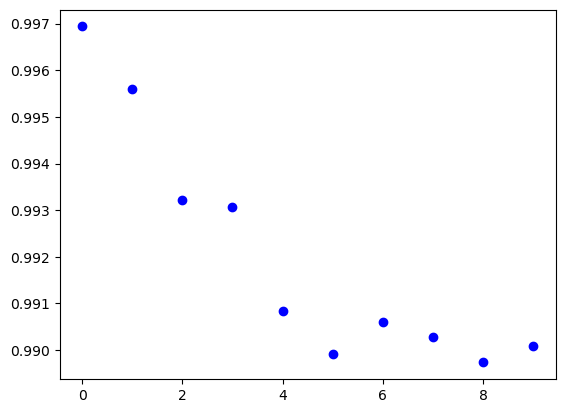

In [13]:
from matplotlib import pyplot as plt
plt.plot(range(10),accuracys,"bo")